In [1]:
install.packages("randomForest","rsample","glue",
                 "caret","naivebayes","LiblineaR",
                 "randomForest", "pROC","e1071")

In [2]:
library(tidyverse)
library(rsample)
library(glue)
library(caret)
library(naivebayes)
library(LiblineaR)
library(randomForest)
library(pROC)


── Attaching packages ──────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


naivebayes 0.9.7 loaded

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Type 'citation("pROC")' for a citation.


Attaching package: ‘

In [3]:
df = read.csv("https://cssbook.net/d/media.csv")
mod = lm(formula = "newspaper ~ age + gender",
         data = df)
# summary(mod) would give a lot more info, 
# but we only care about the coefficients:
mod


Call:
lm(formula = "newspaper ~ age + gender", data = df)

Coefficients:
(Intercept)          age       gender  
   -0.08956      0.06762      0.17666  


In [4]:
gender = c(1,0)
age = c(20,40)
newdata = data.frame(age, gender)
predict(mod, newdata)

1        2 
1.439508 2.615248

In [5]:
df = read.csv("https://cssbook.net/d/media.csv")
df = na.omit(df %>% mutate(
    usesinternet=recode(internet, 
            .default="user", `0`="non-user")))

set.seed(42)
df$usesinternet = as.factor(df$usesinternet)
print("How many people used online news at all?")
print(table(df$usesinternet))


split = initial_split(df, prop = .8)
traindata = training(split)
testdata  = testing(split)

X_train = select(traindata, 
                 c("age", "gender", "education"))
y_train = traindata$usesinternet
X_test = select(testdata, 
                c("age", "gender", "education"))
y_test = testdata$usesinternet

glue("We have {nrow(X_train)} training and ",
     "{nrow(X_test)} test cases.")

[1] "How many people used online news at all?"

non-user     user 
     803     1262 


We have 1652 training and 413 test cases.

In [6]:
myclassifier = train(x = X_train, y = y_train, 
                     method = "naive_bayes")
y_pred = predict(myclassifier, newdata = X_test)

In [7]:
print(confusionMatrix(y_pred, y_test))

print("Confusion matrix:")
confmat = table(testdata$usesinternet, y_pred)
print(confmat)

print("Precision for predicting True internet")
print("users and non-internet-users:")
precision = diag(confmat) / colSums(confmat)
print(precision)


print("Recall for predicting True internet")
print("users and non-internet-users:")
recall = (diag(confmat) / rowSums(confmat))
print(recall)

Confusion Matrix and Statistics

          Reference
Prediction non-user user
  non-user       62   53
  user           99  199
                                          
               Accuracy : 0.632           
                 95% CI : (0.5834, 0.6786)
    No Information Rate : 0.6102          
    P-Value [Acc > NIR] : 0.1958408       
                                          
                  Kappa : 0.1843          
                                          
 Mcnemar's Test P-Value : 0.0002623       
                                          
            Sensitivity : 0.3851          
            Specificity : 0.7897          
         Pos Pred Value : 0.5391          
         Neg Pred Value : 0.6678          
             Prevalence : 0.3898          
         Detection Rate : 0.1501          
   Detection Prevalence : 0.2785          
      Balanced Accuracy : 0.5874          
                                          
       'Positive' Class : non-user        
            

In [8]:
myclassifier = train(x = X_train, y = y_train,
    method = "glm",family = "binomial")
y_pred = predict(myclassifier, newdata = X_test)

In [9]:
# !!! We normalize our features to have M=0 and 
# SD=1. This is necessary as our features are not 
# measured on the same scale, which SVM requires.
# Alternatively, rescale to [0:1] or [-1:1]

myclassifier = train(x = X_train, y = y_train, 
    preProcess = c("center", "scale"), 
                     method = "svmLinear3")
y_pred = predict(myclassifier, newdata = X_test)

In [10]:
myclassifier = train(x = X_train, y = y_train, 
                     method = "rf")
y_pred = predict(myclassifier, newdata = X_test)

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



In [11]:
m = glm(usesinternet ~ age + gender + education, 
        data=traindata, family="binomial")
y_pred = predict(m, newdata = testdata,
                 type = "response")
pred_default = as.factor(ifelse(y_pred>0.5, 
                            "user", "non-user"))

print("Confusion matrix, default threshold (0.5)")
confmat = table(y_test, pred_default)
print(confmat)
print("Recall for predicting True internet
users and non-internet-users:")
print(diag(confmat) / rowSums(confmat))
print("Precision for predicting True internet
users and non-internet-users:")
print(diag(confmat) / colSums(confmat))

[1] "Confusion matrix, default threshold (0.5)"
          pred_default
y_test     non-user user
  non-user       59  102
  user           51  201
[1] "Recall for predicting True internet\nusers and non-internet-users:"
 non-user      user 
0.3664596 0.7976190 
[1] "Precision for predicting True internet\nusers and non-internet-users:"
 non-user      user 
0.5363636 0.6633663 


In [12]:
roc_ = roc(testdata$usesinternet ~ y_pred)
opt = roc_$thresholds[which.max(
    roc_$sensitivities + roc_$specificities)]

print(glue("Confusion matrix with optimal",
           "threshold ({opt}):"))
pred_opt = ifelse(y_pred>opt, "user", "non-user")
confmat = table(y_test, pred_opt)
print(confmat)
print("Recall for predicting True internet")
print("users and non-internet-users:")
print(diag(confmat) / rowSums(confmat))
print("Precision for predicting True internet")
print("users and non-internet-users:")
print(diag(confmat) / colSums(confmat))

Setting levels: control = non-user, case = user

Setting direction: controls < cases



Confusion matrix with optimalthreshold (0.619297246226928):
          pred_opt
y_test     non-user user
  non-user      113   48
  user          103  149
[1] "Recall for predicting True internet"
[1] "users and non-internet-users:"
 non-user      user 
0.7018634 0.5912698 
[1] "Precision for predicting True internet"
[1] "users and non-internet-users:"
 non-user      user 
0.5231481 0.7563452 


Setting levels: control = non-user, case = user

Setting direction: controls < cases



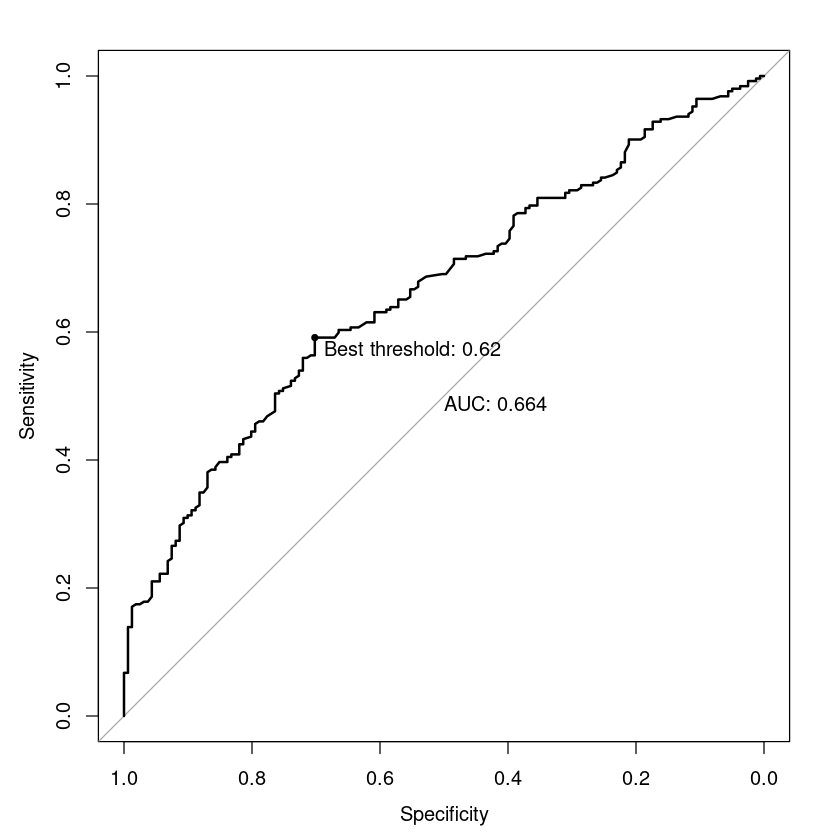

In [13]:
roc_ = roc(testdata$usesinternet ~ y_pred, plot=T,
    print.auc=T, print.thres="best",
    print.thres.pattern="Best threshold: %1.2f")

In [14]:
myclassifier = train(x = X_train, y = y_train,
    method = "glm", family="binomial",
    metric="Accuracy", trControl = trainControl(
     method = "cv", number = 5, 
     returnResamp ="all", savePredictions=TRUE),)
print(myclassifier$resample)
print(myclassifier$results)

   Accuracy     Kappa parameter Resample
1 0.6646526 0.2564808      none    Fold1
2 0.6616314 0.2441998      none    Fold2
3 0.6606061 0.2057079      none    Fold3
4 0.6575758 0.2099241      none    Fold4
5 0.6333333 0.1670491      none    Fold5
  parameter  Accuracy     Kappa AccuracySD    KappaSD
1      none 0.6555598 0.2166724 0.01267959 0.03525159


In [15]:
# Create the grid of parameters
grid = expand.grid(Loss=c("L1","L2"),
                   cost=c(100,1000))

# Train the model using our previously defined 
# parameters
gridsearch = train(x = X_train, y = y_train,
    preProcess = c("center", "scale"), 
    method = "svmLinear3", 
    trControl = trainControl(method = "cv", 
            number = 5),
    tuneGrid = grid)
gridsearch

L2 Regularized Support Vector Machine (dual) with Linear Kernel 

1652 samples
   3 predictor
   2 classes: 'non-user', 'user' 

Pre-processing: centered (3), scaled (3) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1322, 1322, 1321, 1321, 1322 
Resampling results across tuning parameters:

  Loss  cost  Accuracy   Kappa    
  L1     100  0.6458555  0.1994112
  L1    1000  0.5587091  0.1483755
  L2     100  0.6525185  0.2102270
  L2    1000  0.6525185  0.2102270

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were cost = 100 and Loss = L2.